## Import the libraries :

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import networkx as nx
import itertools
from pygsp import graphs, filters, plotting
from sklearn.cluster import KMeans
from sklearn import metrics
import pickle
import os
from collections import Counter

from sklearn import mixture

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## 7.0 Load the data

In [2]:
weights_wt_students=pd.read_pickle("Graphs/students_graph_STI.pkl")
weights_wt_section=pd.read_pickle("Graphs/section_graph_STI.pkl")
weights_wrt_prof=pd.read_pickle("Graphs/prof_graph_STI.pkl")
weights_wrt_assistants=pd.read_pickle("Graphs/assistants_graph_STI.pkl")
weight_requirements_same_course=pd.read_pickle("Graphs/req_course_same_req_graph_STI.pkl")
weight_course_to_requirement=pd.read_pickle("Graphs/req_course_to_req_graph_STI.pkl")
weight_course_same_requirements=pd.read_pickle("Graphs/req_same_course_graph_STI.pkl")

enrol2=pd.read_pickle("../data/cleaned_enrol_STI.pickle")
Courses=enrol2['CourseCodes'].unique()
courses=pd.read_pickle("../data/cleaned_courses_STI.pickle")
courses2=courses[courses.index.isin(Courses)]

courses_index_dico=dict(zip(Courses, np.arange(len(Courses))))

years=pd.read_pickle("Graphs/years.pkl")

# 7. Spectral clustering
## 7.1. On graph wrt students choices

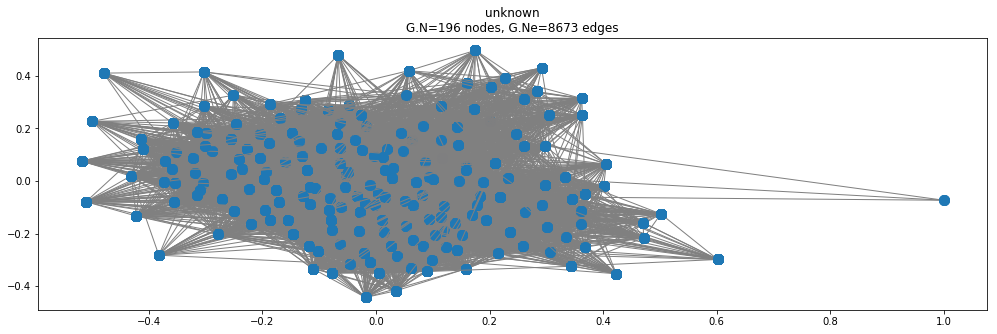

In [3]:
#np.fill_diagonal(weights_wt_students,0)
# Display the graph:
G1s=graphs.Graph(weights_wt_students)
G1s.set_coordinates('spring')
G1s.plot()

array([ 0.        ,  0.1565502 ,  0.20530423,  0.25767806,  0.38140645,
        0.51769111,  0.53610023,  0.63002928,  0.70516134,  0.72438518,
        0.743057  ,  0.75164933,  0.77640165,  0.81698508,  0.83007061,
        0.83146035,  0.8535664 ,  0.85980832,  0.87839163,  0.88204751,
        0.89661888,  0.90573129,  0.92040545,  0.92415164,  0.94067769,
        0.94298885,  0.94804453,  0.9498228 ,  0.95320843,  0.95721626,
        0.95871673,  0.96276235,  0.96398766,  0.96766635,  0.97376804,
        0.97590968,  0.97763472,  0.97965476,  0.98246226,  0.98534866,
        0.98653318,  0.98829862,  0.98966843,  0.98994616,  0.99182304,
        0.99304235,  0.99441315,  0.9959469 ,  0.99771388,  0.99967391])

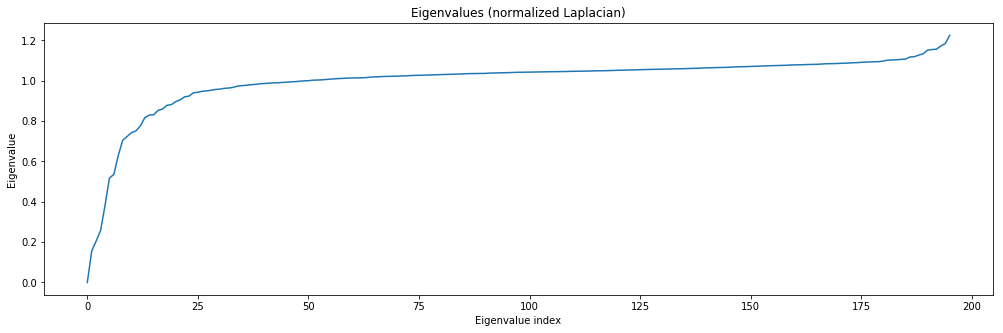

In [4]:
laplacian_1=G1s.compute_laplacian("normalized") #compute the Laplacian of the graph
G1s.compute_fourier_basis(recompute=True)
# Display the eigenvalues:
plt.plot(G1s.e)
plt.title('Eigenvalues (normalized Laplacian)')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.savefig('Graphs/Graph Screenshots/kmeans_eigvals_normLap.png', format='png', dpi=100)
eig_1=G1s.e
eig_1[0:50]

Text(0,0.5,'Eigenvalue')

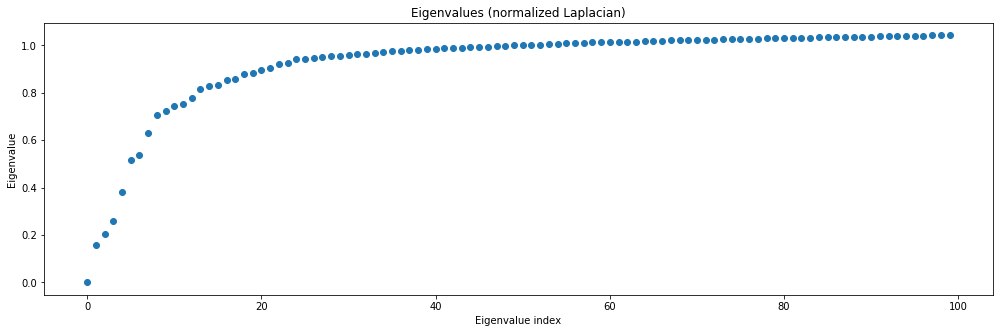

In [5]:
plt.plot(eig_1[0:100], 'o')
plt.title('Eigenvalues (normalized Laplacian)')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')

The eigenvalues are smaller than 2 -> ok since normalized Laplacian.

We can see the largest gap of eigenvalues is after the first eigenvalue. According to the lecture, it suggests k=1 (k=1 cluster) for K-means. But here, we do not want only one cluster and we should not have only one. We could try other values for k with respect to the other large gaps but because its choice is not obvious, we will use other methods in the following to get the value of k.


In [6]:
np.diff(G1s.e[0:50]) # differences between eigenvalues

array([ 0.1565502 ,  0.04875403,  0.05237383,  0.12372839,  0.13628466,
        0.01840913,  0.09392905,  0.07513206,  0.01922384,  0.01867182,
        0.00859233,  0.02475232,  0.04058343,  0.01308553,  0.00138973,
        0.02210605,  0.00624192,  0.01858331,  0.00365588,  0.01457137,
        0.00911241,  0.01467417,  0.00374618,  0.01652605,  0.00231116,
        0.00505567,  0.00177827,  0.00338563,  0.00400783,  0.00150047,
        0.00404562,  0.00122531,  0.00367869,  0.00610169,  0.00214165,
        0.00172504,  0.00202004,  0.0028075 ,  0.0028864 ,  0.00118453,
        0.00176544,  0.00136981,  0.00027773,  0.00187688,  0.00121931,
        0.0013708 ,  0.00153375,  0.00176697,  0.00196003])

## K-means

8


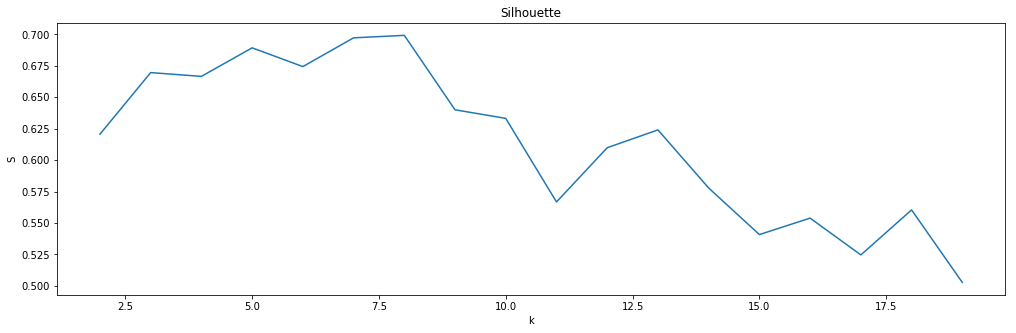

In [7]:
#compute the "silhouette" to get the k:
S=[]
kmax=20
for k in range(2,kmax):
    H1=G1s.U[:,:k]
    D_minus_half_1=np.diag(np.sum(weights_wt_students,1)**(-1/2)) # weighted degrees
    F1=D_minus_half_1@H1
    kmeans_1 = KMeans(n_clusters=k, random_state=0).fit(F1)
    s=0
    labels_1 = kmeans_1.labels_
    centroids=kmeans_1.cluster_centers_
    r=np.arange(k)
    for course in range(len(Courses)):
        dist=scipy.spatial.distance.cdist(centroids,[F1[course,:]], 'euclidean')
        a=dist[labels_1[course]][0]
        b=min(dist[r!=labels_1[course]])[0]
        s+=(b-a)/max(a,b)
    s/=len(Courses)
    S.append(s)

# Display the silhouette:
plt.plot(range(2,kmax),S)
plt.title('Silhouette')
plt.xlabel('k')
plt.ylabel('S')
plt.savefig('Graphs/Graph Screenshots/kmeans_silhouette.png', format='png', dpi=100)
k=np.argmax(S)+2
print(k)

In [8]:
# Keep the first k eigenvectors:
H1=G1s.U[:,:k]
D_minus_half_1=np.diag(np.sum(weights_wt_students,1)**(-1/2)) # weighted degrees
F1_K=D_minus_half_1@H1

In [9]:
# Apply k-means:
kmeans_1 = KMeans(n_clusters=k, random_state=0).fit(F1_K)
labels_1 = kmeans_1.labels_

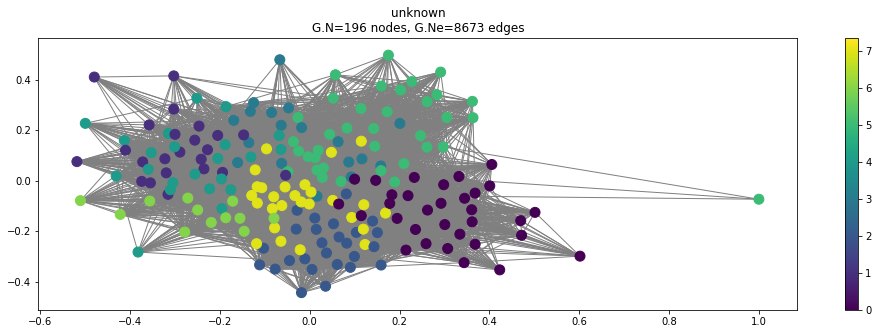

In [10]:
G1s.plot_signal(labels_1)

In [11]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind1=np.where(labels_1==i)[0]
    print(Courses[ind1])
    print([courses2[courses2.index.str.endswith(Courses[ind1][p])].CourseTitleFR.tolist()[0] for p in range(len(ind1))])
    print('\n')



['ME-332' 'ME-312' 'MICRO-312' 'MICRO-331' 'MSE-471' 'MSE-477' 'MSE-485'
 'MSE-440' 'MSE-465' 'MSE-430' 'MSE-420' 'MSE-472' 'MSE-462' 'MSE-461'
 'MSE-474' 'MSE-463' 'MSE-464' 'MSE-466' 'MSE-451' 'MSE-431' 'MSE-484'
 'MSE-480' 'MSE-450' 'MSE-486' 'MSE-437' 'MSE-468' 'MSE-441' 'MSE-442'
 'MSE-423' 'MSE-425' 'MSE-443(a)' 'MSE-424']
['Mécanique vibratoire', 'Conception pour X', 'Composants semiconducteurs', 'Technologie des microstructures I', 'Biomaterials (pour MX)', 'Advanced nanomaterials', 'Tribology', 'Composites technology', 'Thin film fabrication processes', 'Life cycle engineering of polymers', 'Cementitious materials (advanced)', 'Matériaux pierreux et conservation du patrimoine bâti', 'Powder technology', 'Micro and nanostructuration of materials', 'Materials selection', 'Recycling of materials', 'Assembly techniques', 'Wood structures, properties and uses', 'Polymer morphological characterization techniques', 'Physical chemistry of polymeric materials', 'Properties of semicon

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


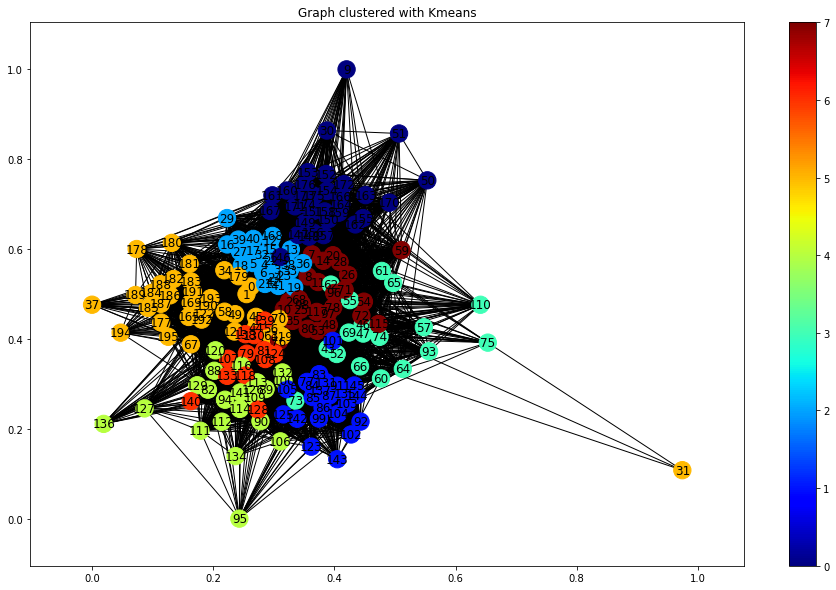

In [12]:
# Display the graph with respect to the clusters assignements:
values=[100*labels_1[node] for node in range(len(labels_1))]
G1=nx.from_numpy_matrix(weights_wt_students)
plt.figure(1,figsize=(16,10))
pos1 = nx.spring_layout(G1)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G1, pos1, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G1, pos1) # plot the labels
nx.draw_networkx_edges(G1, pos1) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with Kmeans')
plt.savefig('Graphs/Graph Screenshots/kmeans_clustering.png', format='png', dpi=100)
plt.show()

## GMM

Then, we tried to use GMM instead of K-means in order to allow elliptical distributions and also soft clustering.

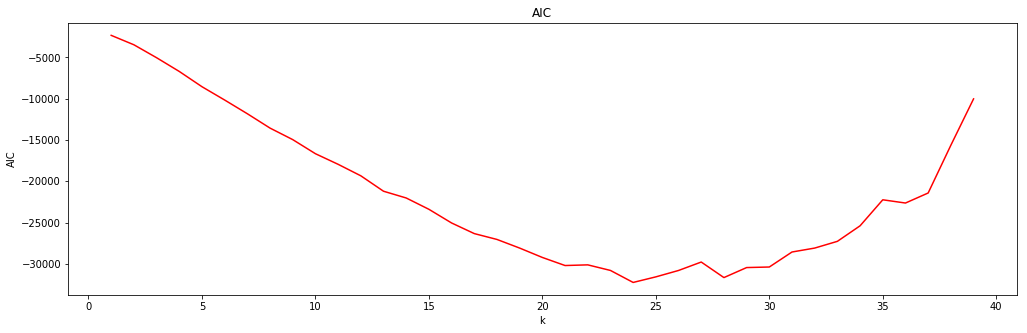

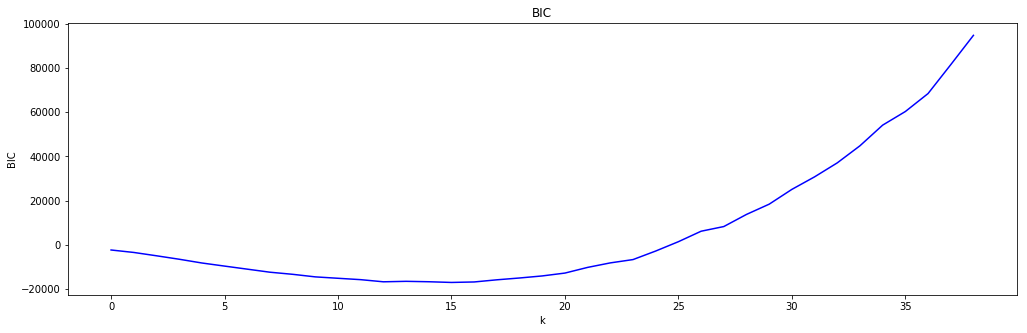

In [13]:
# To determine the number of Gaussians, we compute the AIC and the BIC:
AIC=[]
BIC=[]
for k in range(1,40):
    
    H1=G1s.U[:,:k]
    D_minus_half_1=np.diag(np.sum(weights_wt_students,1)**(-1/2)) # weighted degrees
    F1=D_minus_half_1@H1
    
    g = mixture.GaussianMixture(n_components=k)
    g.fit(F1)
    labels_1b=g.predict(F1)
    AIC.append(g.aic(F1))
    BIC.append(g.bic(F1))
plt.plot(range(1,40),AIC,'r')
plt.title('AIC')
plt.xlabel('k')
plt.ylabel('AIC')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_AIC.png', format='png', dpi=100)
plt.show()
plt.plot(BIC,'b')
plt.title('BIC')
plt.xlabel('k')
plt.ylabel('BIC')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_BIC.png', format='png', dpi=100)
plt.show()

### Hard clustering:

In [14]:
k=np.argmin(BIC)+1
print(k)

# Keep the first k eigenvectors:
H1_gmm_h=G1s.U[:,:k]
D_minus_half_1_gmm_h=np.diag(np.sum(weights_wt_students,1)**(-1/2)) # weighted degrees
F1_gmm_h=D_minus_half_1_gmm_h@H1_gmm_h

# Apply GMM and do the prediction:
g = mixture.GaussianMixture(n_components=k)
g.fit(F1_gmm_h)
labels_1c=g.predict(F1_gmm_h)

16


In [15]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind1=np.where(labels_1c==i)[0]
    print(Courses[ind1])
    print([courses2[courses2.index.str.endswith(Courses[ind1][p])].CourseTitleFR.tolist()[0] for p in range(len(ind1))])
    print('\n')



['MICRO-523' 'EE-535' 'EE-420' 'EE-425' 'EE-530' 'EE-536' 'EE-537' 'EE-532'
 'EE-490(b)' 'EE-434' 'EE-429' 'EE-490(d)' 'EE-428']
['Optical detectors', 'Nanoelectronics', 'Analog circuits design I', 'HF and VHF circuits and techniques I', 'Test of VLSI systems', 'Physical models for micro and nanosystems', 'Modeling of emerging electron devices', 'Integrated circuits technology', 'Lab in EDA based design', 'Hardware systems modeling', 'Fundamentals of VLSI design', 'Lab in microelectronics', 'Introduction to VLSI Design']




['MICRO-431' 'MICRO-432' 'MICRO-430' 'MICRO-443' 'MICRO-520' 'MICRO-566'
 'MICRO-534' 'MICRO-530' 'EE-320' 'EE-330']
['Materials and technology of microfabrication', 'Microelectronics', 'Scaling laws in micro- and nanosystems', 'Analyse de produits et systèmes', 'Laser microprocessing', 'Large-area electronics: devices and materials', 'Advanced MEMS', 'Nanotechnology', 'Circuits intégrés I', 'IC design II']




['ME-421' 'ME-415' 'ME-416' 'ME-523' 'ME-417' 'ME-43

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


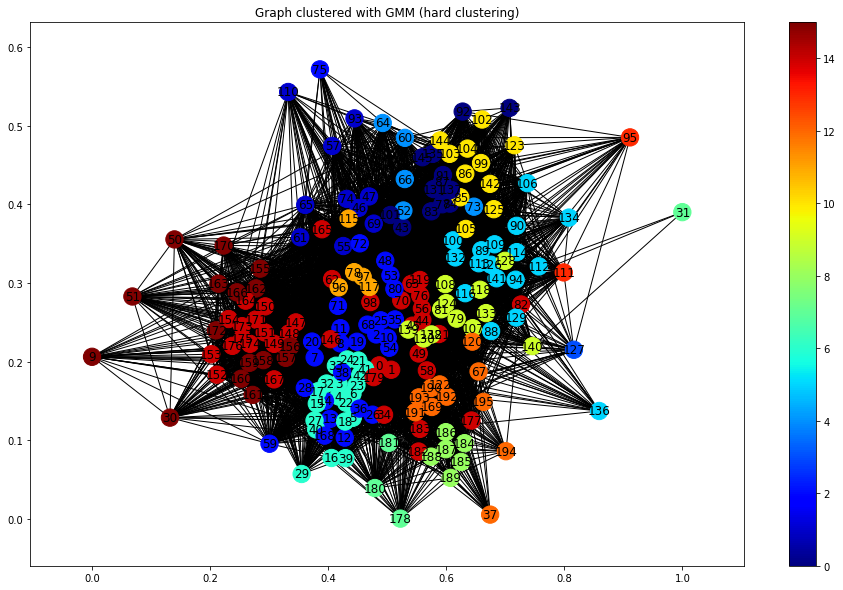

In [16]:
# Display the graph with respect to the clusters assignements:
values=[100*labels_1c[node] for node in range(len(labels_1c))]
G1=nx.from_numpy_matrix(weights_wt_students)
plt.figure(1,figsize=(16,10))
pos1 = nx.spring_layout(G1)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G1, pos1, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G1, pos1) # plot the labels
nx.draw_networkx_edges(G1, pos1) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with GMM (hard clustering)')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_clustering.png', format='png', dpi=100)
plt.show()

### Soft clustering:

In [17]:
k=np.argmin(BIC)+1
print(k)

# Keep the first k eigenvectors:
H1_gmm_s=G1s.U[:,:k]
D_minus_half_1_gmm_s=np.diag(np.sum(weights_wt_students,1)**(-1/2)) # weighted degrees
F1_gmm_s=D_minus_half_1_gmm_s@H1_gmm_s

# Apply GMM and do the predictions:
g = mixture.GaussianMixture(n_components=k)
g.fit(F1_gmm_s)
labels_1b=g.predict_proba(F1_gmm_s)

16


In [18]:
r=np.arange(k)
multi_labels=[list(r[labels_1b[p]>0.1]) for p in range(len(labels_1b))] #assignements for probability > 0.1

labels_matrix=[]
for p in range(k):
    lab=[]
    for q in range(len(multi_labels)):
        if p in multi_labels[q]:
            lab.append(q)
    labels_matrix.append(lab)

In [19]:
print(multi_labels)

[[1], [1], [7], [11], [11], [11], [11], [7], [7], [7], [7], [7], [7], [7], [7], [11], [11], [11], [11], [7], [7], [11], [11], [11], [11], [7], [7], [11], [7], [11], [15], [9], [11], [11], [1], [0], [7], [1], [7], [11], [11], [11], [11], [12], [0], [1], [2], [2], [0], [1], [15], [15], [5], [0], [0], [2], [0], [2], [1], [7], [5], [2], [11], [1], [5], [2], [5], [0], [7], [2], [1], [7], [0], [5], [2], [0], [1], [12], [10], [6], [0], [6], [0], [12], [12], [8], [8], [12], [13], [13], [13], [12], [12], [2], [13], [3], [10], [10], [11], [8], [13], [12], [8], [8], [8], [8], [13], [6], [6], [13], [2], [3], [13], [13], [13], [10], [13], [10], [6], [1], [13], [1], [1], [8], [6], [13], [13], [3], [6], [13], [6], [12], [13], [6], [13], [12], [13], [12], [6], [6], [6], [13], [8], [12], [8], [12], [4], [4], [4], [4], [4], [4], [4], [4], [4], [15], [15], [15], [15], [15], [15], [15], [15], [15], [4], [1], [15], [4], [7], [1], [15], [4], [15], [4], [4], [4], [4], [1], [9], [1], [9], [9], [1], [1], [14],

In [20]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind1=labels_matrix[i]
    print(Courses[ind1])
    print([courses2[courses2.index.str.endswith(Courses[ind1][p])].CourseTitleFR.tolist()[0] for p in range(len(ind1))])
    print('\n')



['ME-425' 'MICRO-511' 'MICRO-453' 'MICRO-510' 'MICRO-452' 'MICRO-512'
 'MICRO-513' 'MICRO-553' 'MICRO-570' 'EE-461' 'EE-554' 'BIOENG-451'
 'BIOENG-450']
['Model predictive control', 'Image processing I', 'Robotics practicals', "Commande d'actionneurs à l'aide d'un microprocesseur + TP", 'Mobile robots', 'Image processing II', 'Signal processing for functional brain imaging', 'Haptic human robot interfaces', 'Advanced machine learning', 'Transducteurs et entraînements intégrés', 'Automatic speech processing', 'Scientific literature analysis in Neuroscience', 'In Silico neuroscience']




['ME-482' 'ME-481' 'ME-484' 'ME-232' 'MICRO-560' 'MICRO-561' 'MICRO-562'
 'MICRO-568' 'MICRO-514' 'MICRO-455' 'EE-511' 'EE-515' 'EE-516' 'MSE-479'
 'MSE-403' 'BIOENG-445' 'BIOENG-442' 'BIOENG-447' 'BIOENG-444' 'BIOENG-448'
 'BIOENG-449' 'BIOENG-486' 'BIOENG-404']
['Biomechanics of the musculoskeletal system', 'Biomechanics of the cardiovascular system', 'Numerical methods in biomechanics', 'Mécanique 

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


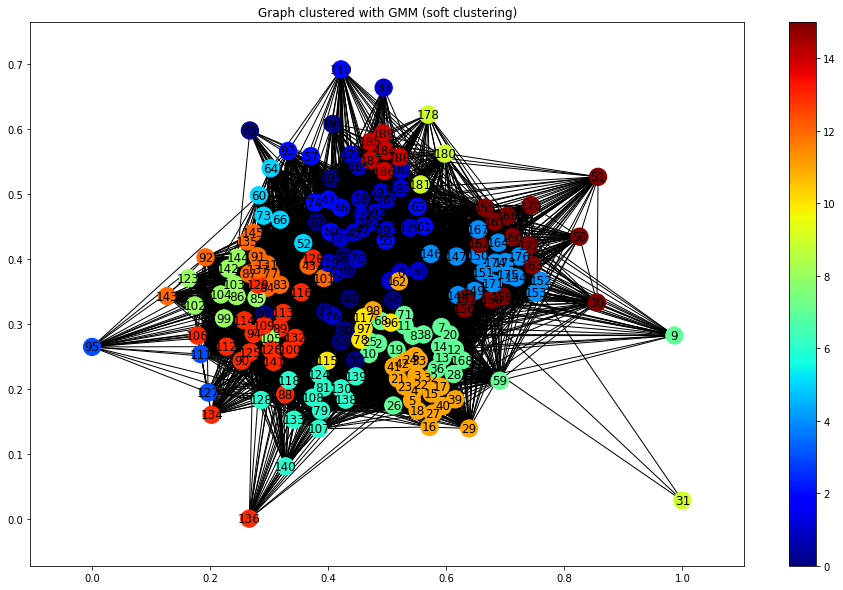

In [21]:
# Display the graph with respect to the clusters assignements:
values=[100*np.mean(multi_labels[node]) for node in range(len(multi_labels))]
G1=nx.from_numpy_matrix(weights_wt_students)
plt.figure(1,figsize=(16,10))
pos1 = nx.spring_layout(G1)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G1, pos1, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G1, pos1) # plot the labels
nx.draw_networkx_edges(G1, pos1) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with GMM (soft clustering)')
plt.show()

## 7.2. On graph wrt courses sections

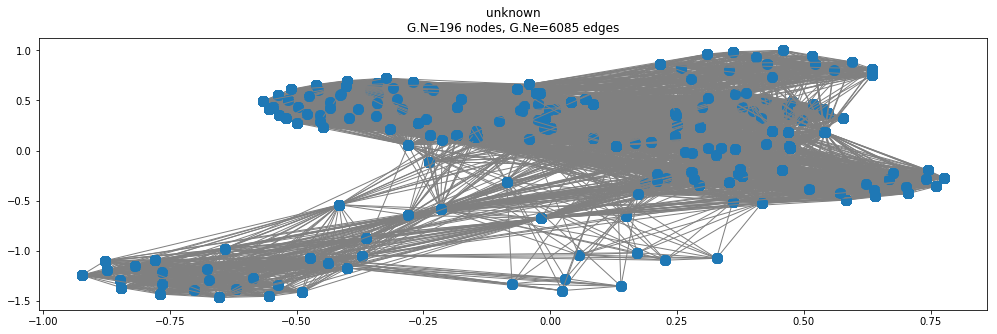

In [22]:
np.fill_diagonal(weights_wt_section,0)
G2s=graphs.Graph(weights_wt_section)
G2s.set_coordinates('spring')
G2s.plot()

array([ 0.        ,  0.10428232,  0.26429876,  0.36439757,  0.46419187,
        0.52914788,  0.55198999,  0.77125416,  0.82409286,  0.85945142,
        0.88526891,  0.89520102,  0.92748903,  0.93847608,  0.95120908,
        0.9773186 ,  0.98274294,  0.995782  ,  1.00669785,  1.00920809,
        1.01115928,  1.01388889,  1.01388889,  1.01388889,  1.01388889,
        1.01388889,  1.01388889,  1.01388889,  1.01388889,  1.01388889])

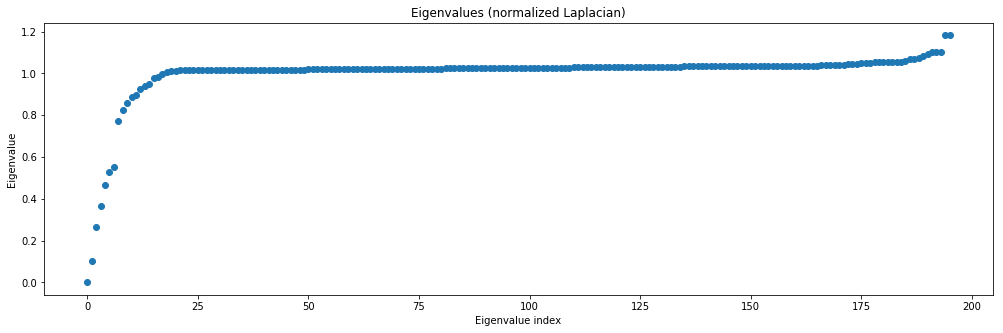

In [23]:
laplacian_2=G2s.compute_laplacian("normalized")
G2s.compute_fourier_basis(recompute=True)
plt.plot(G2s.e, 'o')
plt.title('Eigenvalues (normalized Laplacian)')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
eig_2=G2s.e
eig_2[0:30]

In [24]:
np.diff(eig_2[0:30])

array([  1.04282315e-01,   1.60016442e-01,   1.00098817e-01,
         9.97942975e-02,   6.49560134e-02,   2.28421081e-02,
         2.19264171e-01,   5.28386914e-02,   3.53585667e-02,
         2.58174829e-02,   9.93211680e-03,   3.22880123e-02,
         1.09870448e-02,   1.27330046e-02,   2.61095199e-02,
         5.42434004e-03,   1.30390585e-02,   1.09158438e-02,
         2.51024745e-03,   1.95118278e-03,   2.72961248e-03,
         6.66133815e-16,   0.00000000e+00,   2.22044605e-16,
         2.22044605e-16,   2.22044605e-16,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

The eigenvalues are smaller than 2 -> ok since normalized Laplacian.

The number k for k-means should be defined as the number such that there is a gap in the Laplacian spectrum after the k-th eigenvalue. Here, it seems the main gap is after the 7th eigenvalue: 0.55198999

Thus, we will try k=7 for k-means.

But before that, let's compute the matrix H of first k eigenvectors of L_norm

In [25]:
k=7 #12 all, 7 STI only

# Keep the first k eigenvectors:
H2=G2s.U[:,:k]
D_minus_half_2=np.diag(np.sum(weights_wt_section,1)**(-1/2)) # weighted degrees
F2=D_minus_half_2@H2

In [26]:
# Apply K-means and do the predictions:
kmeans_2 = KMeans(n_clusters=k, random_state=0).fit(F2)
labels_2 = kmeans_2.labels_

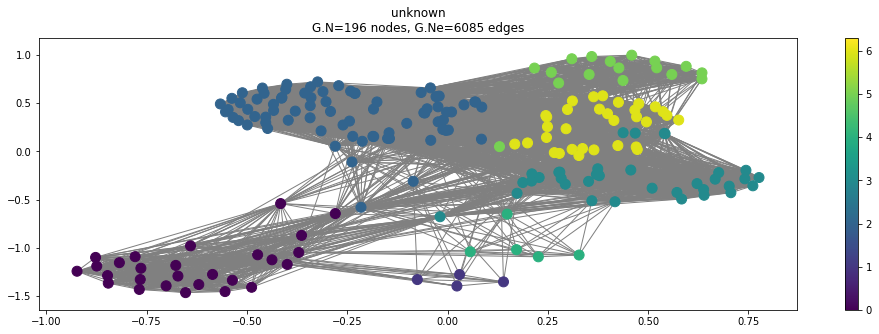

In [27]:
G2s.plot_signal(labels_2)

In [28]:
# Display the obtained clusters:
for i in range(k):
    print('\n')
    ind2=np.where(labels_2==i)[0]
    print(Courses[ind2])
    print([courses2[courses2.index.str.endswith(Courses[ind2][p])].CourseTitleFR.tolist()[0] for p in range(len(ind2))])
    print('\n')



['MSE-471' 'MSE-477' 'MSE-485' 'MSE-440' 'MSE-465' 'MSE-430' 'MSE-420'
 'MSE-472' 'MSE-462' 'MSE-461' 'MSE-463' 'MSE-464' 'MSE-466' 'MSE-451'
 'MSE-431' 'MSE-484' 'MSE-480' 'MSE-450' 'MSE-486' 'MSE-437' 'MSE-468'
 'MSE-441' 'MSE-442' 'MSE-423' 'MSE-425' 'MSE-443(a)' 'MSE-424']
['Biomaterials (pour MX)', 'Advanced nanomaterials', 'Tribology', 'Composites technology', 'Thin film fabrication processes', 'Life cycle engineering of polymers', 'Cementitious materials (advanced)', 'Matériaux pierreux et conservation du patrimoine bâti', 'Powder technology', 'Micro and nanostructuration of materials', 'Recycling of materials', 'Assembly techniques', 'Wood structures, properties and uses', 'Polymer morphological characterization techniques', 'Physical chemistry of polymeric materials', 'Properties of semiconductors and related nanostructures', 'Dielectric properties of materials', 'Electron microscopy: advanced methods', 'Organic electronic materials - synthesis, applications, properties', 'P

## 7.3 On all the graphs

In [29]:
#Normalize the weights matrices:
weight_matrices = [weights_wt_students, weights_wrt_assistants, weights_wrt_prof, weights_wt_section, weight_course_same_requirements, weight_course_to_requirement, weight_requirements_same_course]

for i in range(len(weight_matrices)):
    # Set the diagonal of the matrix to 0
    np.fill_diagonal(weight_matrices[i], 0)
    weight_matrices[i] = weight_matrices[i]/np.max(weight_matrices[i].ravel())

In [30]:
#do a weighted sum of the different weight matrices:
weight_different_graph = [0.2,0,0,0,0,0,1]
W_all = weight_different_graph[0]*weight_matrices[0]
for i in range(1, len(weight_matrices)):
    W_all = W_all + weight_different_graph[i]*weight_matrices[i]

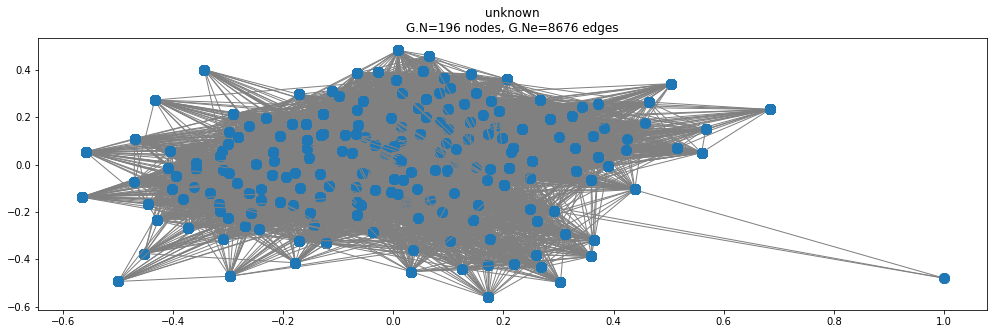

In [31]:
G_alls=graphs.Graph(W_all)
G_alls.set_coordinates('spring')
G_alls.plot()

array([ 0.        ,  0.15784418,  0.20739095,  0.24379396,  0.31327725,
        0.40095287,  0.43251946,  0.4681233 ,  0.50757122,  0.52715233,
        0.56322464,  0.60090731,  0.60435832,  0.66666272,  0.69853882,
        0.74188838,  0.74881338,  0.77047323,  0.77657288,  0.79064947,
        0.81114105,  0.82834581,  0.84425946,  0.85365365,  0.86210985,
        0.87001563,  0.88412758,  0.89378336,  0.90443338,  0.91465425])

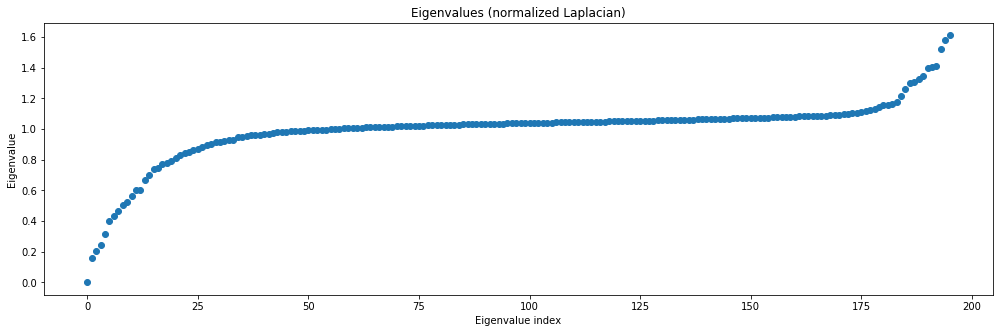

In [32]:
laplacian_all=G_alls.compute_laplacian("normalized")
G_alls.compute_fourier_basis(recompute=True)
plt.plot(G_alls.e, 'o')
plt.title('Eigenvalues (normalized Laplacian)')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
eig_all=G_alls.e
eig_all[0:30]

In [33]:
np.diff(eig_all[0:30])

array([ 0.15784418,  0.04954677,  0.03640301,  0.06948329,  0.08767562,
        0.03156659,  0.03560384,  0.03944792,  0.01958111,  0.03607231,
        0.03768267,  0.00345101,  0.06230439,  0.0318761 ,  0.04334956,
        0.00692501,  0.02165985,  0.00609965,  0.01407659,  0.02049158,
        0.01720476,  0.01591365,  0.0093942 ,  0.0084562 ,  0.00790577,
        0.01411196,  0.00965577,  0.01065002,  0.01022087])

The eigenvalues are smaller than 2 -> ok since normalized Laplacian.

We can see the largest gap of eigenvalues is after the first eigenvalue. According to the lecture, it suggests k=1 (k=1 cluster) for K-means. But here, we do not want only one cluster and we should not have only one. We could try other values for k with respect to the other large gaps but because its choice is not obvious, we will use other methods in the following to get the value of k.

## K-means

11


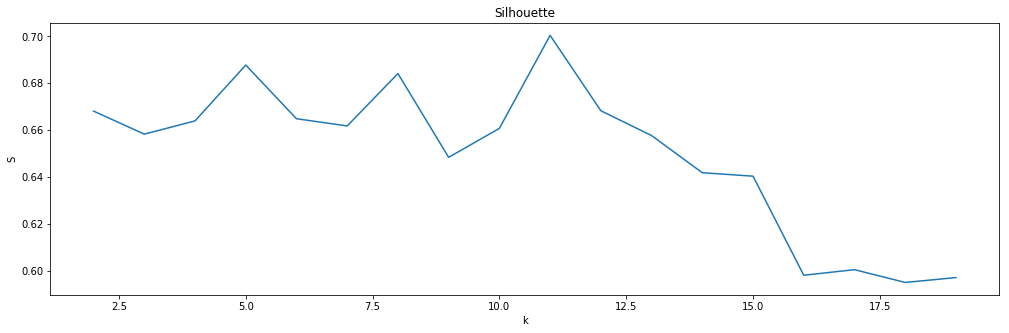

In [34]:
#silhouette:
S=[]
kmax=20
for k in range(2,kmax):
    H=G_alls.U[:,:k]
    D_minus_half=np.diag(np.sum(W_all,1)**(-1/2)) # weighted degrees
    F=D_minus_half@H
    kmeans = KMeans(n_clusters=k, random_state=0).fit(F)
    s=0
    labels = kmeans.labels_
    centroids=kmeans.cluster_centers_
    r=np.arange(k)
    for course in range(len(Courses)):
        dist=scipy.spatial.distance.cdist(centroids,[F[course,:]], 'euclidean')
        a=dist[labels[course]][0]
        b=min(dist[r!=labels[course]])[0]
        s+=(b-a)/max(a,b)
    s/=len(Courses)
    S.append(s)

plt.plot(range(2,kmax),S)
plt.title('Silhouette')
plt.xlabel('k')
plt.ylabel('S')
plt.savefig('Graphs/Graph Screenshots/kmeans_silhouette_merged_graph.png', format='png', dpi=100)
k=np.argmax(S)+2
print(k)

In [35]:
# Keep the first k eigenvectors:
H_all_K=G_alls.U[:,:k]
D_minus_half_all_K=np.diag(np.sum(W_all,1)**(-1/2)) # weighted degrees
F_all_K=D_minus_half_all_K@H_all_K

In [36]:
# Apply K-means :
kmeans_all = KMeans(n_clusters=k, random_state=0).fit(F_all_K)
labels_all = kmeans_all.labels_

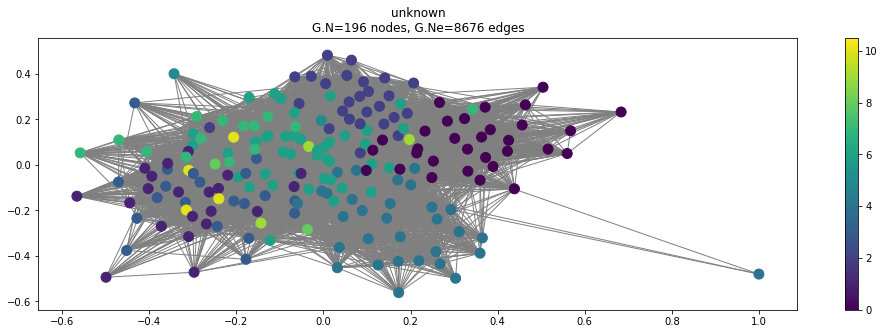

In [37]:
G_alls.plot_signal(labels_all)

In [38]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind_all=np.where(labels_all==i)[0]
    print(Courses[ind_all])
    print([courses2[courses2.index.str.endswith(Courses[ind_all][p])].CourseTitleFR.tolist()[0] for p in range(len(ind_all))])
    print('\n')



['ME-332' 'ME-312' 'MICRO-312' 'MICRO-331' 'MSE-471' 'MSE-477' 'MSE-485'
 'MSE-440' 'MSE-465' 'MSE-430' 'MSE-420' 'MSE-462' 'MSE-461' 'MSE-474'
 'MSE-463' 'MSE-464' 'MSE-466' 'MSE-451' 'MSE-431' 'MSE-484' 'MSE-480'
 'MSE-450' 'MSE-486' 'MSE-437' 'MSE-468' 'MSE-441' 'MSE-442' 'MSE-423'
 'MSE-425' 'MSE-443(a)' 'MSE-424']
['Mécanique vibratoire', 'Conception pour X', 'Composants semiconducteurs', 'Technologie des microstructures I', 'Biomaterials (pour MX)', 'Advanced nanomaterials', 'Tribology', 'Composites technology', 'Thin film fabrication processes', 'Life cycle engineering of polymers', 'Cementitious materials (advanced)', 'Powder technology', 'Micro and nanostructuration of materials', 'Materials selection', 'Recycling of materials', 'Assembly techniques', 'Wood structures, properties and uses', 'Polymer morphological characterization techniques', 'Physical chemistry of polymeric materials', 'Properties of semiconductors and related nanostructures', 'Dielectric properties of mate

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


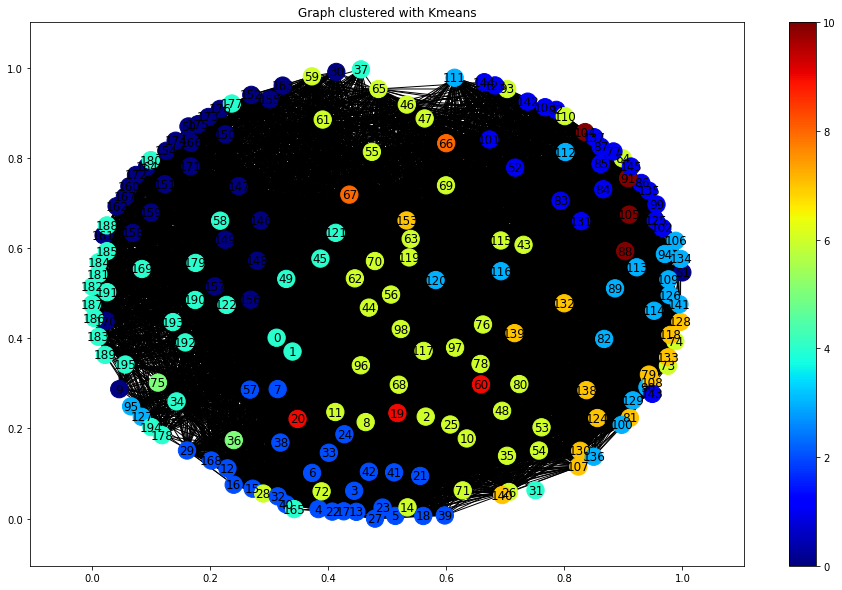

In [39]:
# Display the graph with respect to the clusters assignements:
values=[100*labels_all[node] for node in range(len(labels_all))]
G_all=nx.from_numpy_matrix(W_all)
plt.figure(1,figsize=(16,10))
pos_all = nx.spring_layout(G_all)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G_all, pos_all, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G_all, pos_all) # plot the labels
nx.draw_networkx_edges(G_all, pos_all) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with Kmeans')
plt.savefig('Graphs/Graph Screenshots/kmeans_clustering_merged_graph.png', format='png', dpi=100)
plt.show()

## GMM

Then, we tried to use GMM instead of K-means in order to allow elliptical distributions and also soft clustering.

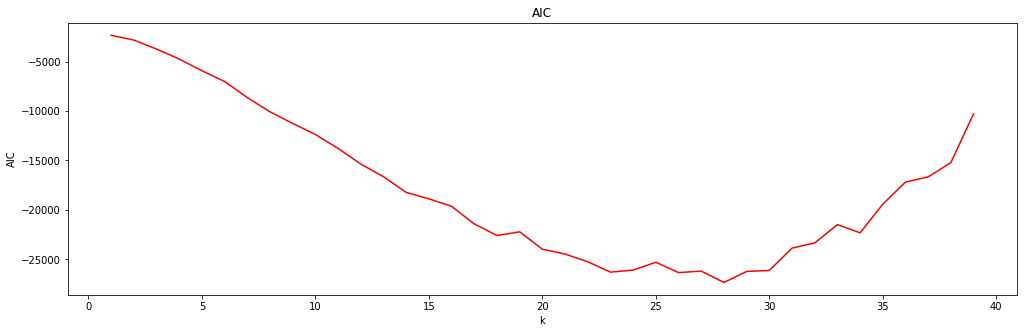

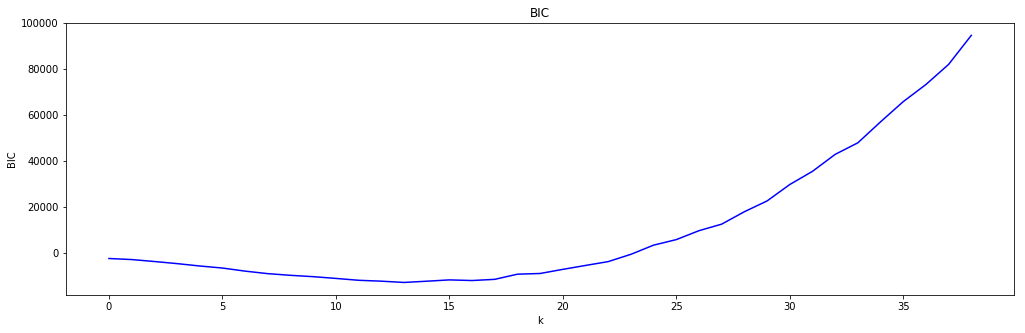

In [40]:
# To determine the number of Gaussians, we compute the AIC and the BIC:
AIC=[]
BIC=[]
for k in range(1,40):
    
    H=G_alls.U[:,:k]
    D_minus_half=np.diag(np.sum(W_all,1)**(-1/2)) # weighted degrees
    F=D_minus_half@H
    
    g = mixture.GaussianMixture(n_components=k)
    g.fit(F)
    labels=g.predict(F)
    AIC.append(g.aic(F))
    BIC.append(g.bic(F))
    
plt.plot(range(1,40),AIC,'r')
plt.title('AIC')
plt.xlabel('k')
plt.ylabel('AIC')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_AIC_merged_graph.png', format='png', dpi=100)
plt.show()

plt.plot(BIC,'b')
plt.title('BIC')
plt.xlabel('k')
plt.ylabel('BIC')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_BIC_merged_graph.png', format='png', dpi=100)
plt.show()

### Hard clustering

In [41]:
k=np.argmin(BIC)+1
print(k)

# Keep the first k eigenvectors:
H_all_gmm_h=G_alls.U[:,:k]
D_minus_half_all_gmm_h=np.diag(np.sum(W_all,1)**(-1/2)) # weighted degrees
F_all_gmm_h=D_minus_half_all_gmm_h@H_all_gmm_h

# Apply GMM
g = mixture.GaussianMixture(n_components=k)
g.fit(F_all_gmm_h)
labels_allc=g.predict(F_all_gmm_h)

14


In [42]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind_all=np.where(labels_allc==i)[0]
    print(Courses[ind_all])
    print([courses2[courses2.index.str.endswith(Courses[ind_all][p])].CourseTitleFR.tolist()[0] for p in range(len(ind_all))])
    print('\n')



['ME-332' 'ME-312' 'MICRO-312' 'MICRO-331' 'MSE-471' 'MSE-477' 'MSE-485'
 'MSE-440' 'MSE-465' 'MSE-430' 'MSE-420' 'MSE-462' 'MSE-461' 'MSE-474'
 'MSE-463' 'MSE-451' 'MSE-431' 'MSE-484' 'MSE-480' 'MSE-450' 'MSE-486'
 'MSE-437' 'MSE-468' 'MSE-441' 'MSE-442' 'MSE-423' 'MSE-425' 'MSE-443(a)'
 'MSE-424']
['Mécanique vibratoire', 'Conception pour X', 'Composants semiconducteurs', 'Technologie des microstructures I', 'Biomaterials (pour MX)', 'Advanced nanomaterials', 'Tribology', 'Composites technology', 'Thin film fabrication processes', 'Life cycle engineering of polymers', 'Cementitious materials (advanced)', 'Powder technology', 'Micro and nanostructuration of materials', 'Materials selection', 'Recycling of materials', 'Polymer morphological characterization techniques', 'Physical chemistry of polymeric materials', 'Properties of semiconductors and related nanostructures', 'Dielectric properties of materials', 'Electron microscopy: advanced methods', 'Organic electronic materials - sy

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


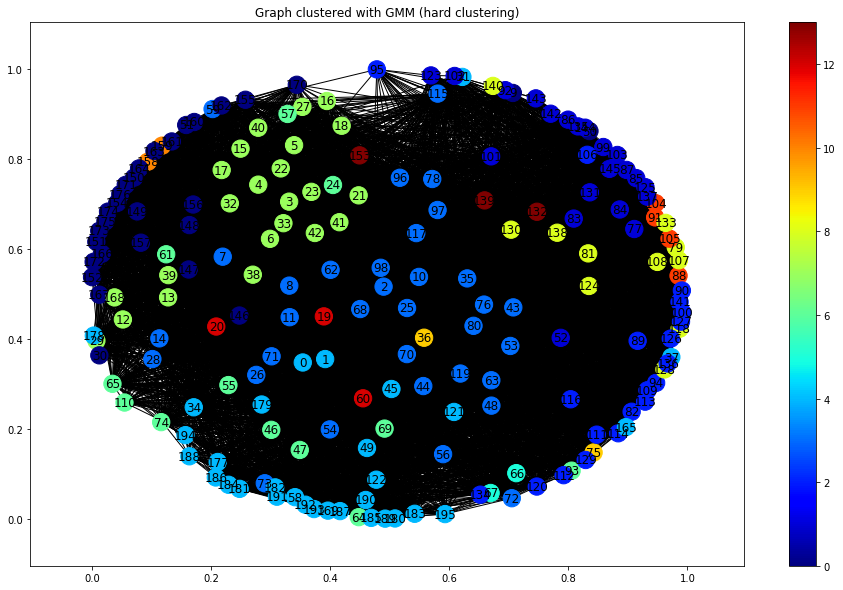

In [43]:
# Display the graph with respect to the clusters assignements:
values=[100*labels_allc[node] for node in range(len(labels_allc))]
G_all=nx.from_numpy_matrix(W_all)
plt.figure(1,figsize=(16,10))
pos_all = nx.spring_layout(G_all)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G_all, pos_all, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G_all, pos_all) # plot the labels
nx.draw_networkx_edges(G_all, pos_all) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with GMM (hard clustering)')
plt.savefig('Graphs/Graph Screenshots/GMM_hard_clustering_merged_graph.png', format='png', dpi=100)
plt.show()

### Soft clustering

In [44]:
k=np.argmin(BIC)+1
print(k)

# Keep the first k eigenvectors:
H_all_gmm_s=G_alls.U[:,:k]
D_minus_half_all_gmm_s=np.diag(np.sum(W_all,1)**(-1/2)) # weighted degrees
F_all_gmm_s=D_minus_half_all_gmm_s@H_all_gmm_s

# Apply GMM:
g = mixture.GaussianMixture(n_components=k)
g.fit(F_all_gmm_s)
labels_allb=g.predict_proba(F_all_gmm_s)

14


In [45]:
r=np.arange(k)
multi_labels_all=[list(r[labels_allb[p]>0.1]) for p in range(len(labels_allb))] # assignements with probability > 0.1

labels_matrix_all=[]
for p in range(k):
    lab=[]
    for q in range(len(multi_labels_all)):
        if p in multi_labels_all[q]:
            lab.append(q)
    labels_matrix_all.append(lab)

In [46]:
print(multi_labels_all)

[[1], [1], [8], [6], [6], [6], [6], [8], [8], [3], [8], [8], [6], [6], [8], [6], [6], [6], [6], [13], [13], [6], [6], [6], [6], [8], [8], [6], [8], [6], [3], [12], [6], [6], [1], [8], [5], [12], [6], [6], [6], [6], [6], [1], [1], [1], [7], [7], [8], [12], [3], [3], [1], [8], [8], [7], [1], [10], [12], [8], [13], [7], [1], [1], [7], [7], [9], [9], [8], [7], [1], [8], [8], [1], [7], [5], [1], [0], [8], [2], [8], [2], [4], [0], [0], [0], [0], [0], [0], [4], [4], [0], [0], [7], [4], [4], [8], [8], [8], [0], [1], [0], [0], [0], [0], [0], [4], [2], [2], [4], [7], [4], [4], [4], [4], [8], [4], [8], [2], [1], [1], [12], [12], [0], [2], [0], [4], [4], [2], [4], [2], [0], [11], [11], [4], [0], [4], [0], [11], [11], [2], [4], [0], [0], [0], [0], [3], [3], [3], [3], [3], [3], [3], [11], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [1], [3], [3], [6], [12], [3], [3], [3], [3], [3], [3], [3], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [12], [1

In [47]:
# Display all the obtained clusters:
for i in range(k):
    print('\n')
    ind_all=labels_matrix_all[i]
    print(Courses[ind_all])
    print([courses2[courses2.index.str.endswith(Courses[ind_all][p])].CourseTitleFR.tolist()[0] for p in range(len(ind_all))])
    print('\n')



['EE-535' 'EE-420' 'EE-425' 'EE-432' 'EE-520' 'EE-530' 'EE-549' 'EE-536'
 'EE-537' 'EE-525' 'EE-532' 'EE-521' 'EE-421' 'EE-431' 'EE-598' 'EE-543'
 'EE-539' 'EE-490(b)' 'EE-434' 'EE-429' 'EE-517' 'EE-490(d)' 'EE-518'
 'EE-428']
['Nanoelectronics', 'Analog circuits design I', 'HF and VHF circuits and techniques I', 'Hardware systems modeling I', 'Advanced analog and RF integrated circuits design I', 'Test of VLSI systems', 'Propagation of acoustic waves', 'Physical models for micro and nanosystems', 'Modeling of emerging electron devices', 'HF and VHF circuits and techniques II', 'Integrated circuits technology', 'Advanced analog and RF integrated circuits design II', 'Analog circuits design II', 'Advanced VLSI design', 'Advanced lab in electrical engineering', 'Advanced wireless communications: algorithms and architectures', 'Electrical filters', 'Lab in EDA based design', 'Hardware systems modeling', 'Fundamentals of VLSI design', 'Bio-nano-chip design', 'Lab in microelectronics', 'A

/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/al/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


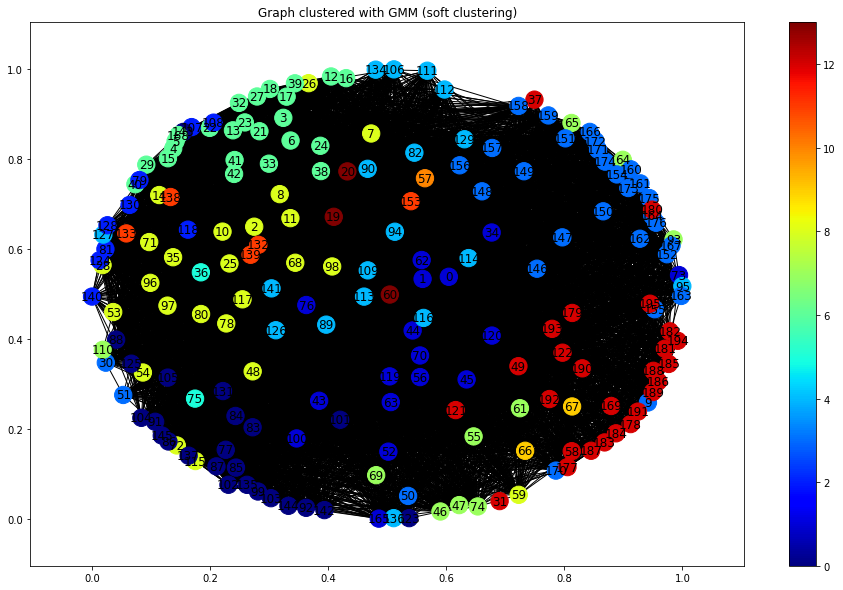

In [48]:
# Display the graph with respect to the clusters assignements:
values=[100*np.mean(multi_labels_all[node]) for node in range(len(multi_labels_all))]
G_all=nx.from_numpy_matrix(W_all)
plt.figure(1,figsize=(16,10))
pos_all = nx.spring_layout(G_all)
cmap=plt.get_cmap('jet')
nx.draw_networkx_nodes(G_all, pos_all, cmap=cmap, node_color = values) # plot the nodes
nx.draw_networkx_labels(G_all, pos_all) # plot the labels
nx.draw_networkx_edges(G_all, pos_all) # plot the edges
sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0, vmax=(k-1)))
sm._A = []
plt.colorbar(sm)
plt.title('Graph clustered with GMM (soft clustering)')
plt.show()

# 8. Recommandation

Here, we create 2 functions in order to do the recommandations. The first one does the recommandation with respect to the choices of the students and the second one also takes into consideration the requirements.

## 8.1 Recommandation based on the students choices

In [49]:
def suggest_wrt1(course):
    
    # Deal with the case course is a string and not a list of strings:
    if type(course)==str:
        course=[course]

    print('Results with K-means:\n')
    L=[]
    indices1=[]
    for q in range(len(course)):
        L.append(labels_1[courses_index_dico[course[q]]]) #list the labels of the courses in course
        indices1.append(courses_index_dico[course[q]]) #indices of the chosen course of course

    L=Counter(L).most_common(1)[0][0] #keep the label L of the most common cluster
    ind=np.where(labels_1==L)[0] # get the indices of the courses of the cluster
    indices1=np.array(indices1) 
    indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster

    # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
    dist=scipy.spatial.distance.cdist(F1_K[ind,:],F1_K[indices,:], 'euclidean')
    dist=np.mean(dist, axis=1)
    
    # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
    ind=ind[np.argsort(dist)]    
    print(Courses[ind])
    print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
    print('\n')
    
    print('\nResults with GMM soft-clustering:\n')
    if len(course)==1:
        L=multi_labels[courses_index_dico[course[0]]] #keep the labels L of the clusters
    else:
        L=[item for q in range(len(course)) for item in multi_labels[courses_index_dico[course[q]]]]
        L=[Counter(L).most_common(1)[0][0]] #keep the label L of the most common cluster
        
    for p in range(len(L)):
        ind=np.array(labels_matrix[L[p]]) # get the indices of the courses of the cluster
        indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster
        
        # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
        dist=scipy.spatial.distance.cdist(F1_gmm_s[ind,:],F1_gmm_s[indices,:], 'euclidean')
        dist=np.mean(dist, axis=1)
        
        # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
        ind=ind[np.argsort(dist)]
        print(Courses[ind])
        print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
        print('\n')

    print('\nResults with GMM hard-clustering:\n')
    L=[]
    for q in range(len(course)):
        L.append(labels_1c[courses_index_dico[course[q]]])
    L=Counter(L).most_common(1)[0][0] #keep the label L of the most common cluster
    ind=np.where(labels_1c==L)[0] # get the indices of the courses of the cluster
    indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster

    # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
    dist=scipy.spatial.distance.cdist(F1_gmm_h[ind,:],F1_gmm_h[indices,:], 'euclidean')
    dist=np.mean(dist, axis=1)
    
    # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
    ind=ind[np.argsort(dist)]
    print(Courses[ind])
    print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
    

In [50]:
suggest_wrt1('EE-554')

Results with K-means:

['EE-554' 'EE-512' 'EE-445' 'EE-555' 'EE-553' 'EE-451' 'EE-490(e)' 'EE-549'
 'EE-440' 'EE-490(f)' 'EE-442' 'EE-550' 'EE-551' 'EE-540' 'EE-345'
 'EE-490(a)' 'EE-514' 'EE-490(g)' 'EE-593' 'EE-548' 'EE-556' 'EE-552']
['Automatic speech processing', 'Biomedical signal processing', 'Microwaves', 'Systems and architectures for signal processing', 'Speech processing', 'Image analysis and pattern recognition', 'Lab in microwaves', 'Propagation of acoustic waves', 'Photonic systems and technology', 'Lab in signal and image processing', 'Wireless receivers: algorithms and architectures', 'Image and video processing', 'Image communication', 'Optical communications', 'Rayonnement et antennes', 'Lab in acoustics', 'Brain computer interaction', 'Lab on app development for tablets and smartphones', 'Social media', 'Audio', 'Mathematics of data: from theory to computation', 'Media security']



Results with GMM soft-clustering:

['EE-554' 'MICRO-511' 'MICRO-512' 'ME-425' 'EE-461

In [51]:
c=['EE-535', 'EE-420']
print([courses2[courses2.index.str.endswith(c[p])].CourseTitleFR.tolist()[0] for p in range(len(c))])
print('\n')
suggest_wrt1(c)

['Nanoelectronics', 'Analog circuits design I']


Results with K-means:

['EE-535' 'EE-420' 'EE-429' 'EE-490(b)' 'EE-530' 'EE-425' 'EE-537' 'EE-536'
 'EE-432' 'EE-434' 'EE-520' 'EE-428' 'EE-532' 'EE-421' 'EE-517' 'EE-518'
 'EE-431' 'EE-521' 'EE-490(d)' 'EE-525' 'EE-543' 'EE-539' 'EE-598']
['Nanoelectronics', 'Analog circuits design I', 'Fundamentals of VLSI design', 'Lab in EDA based design', 'Test of VLSI systems', 'HF and VHF circuits and techniques I', 'Modeling of emerging electron devices', 'Physical models for micro and nanosystems', 'Hardware systems modeling I', 'Hardware systems modeling', 'Advanced analog and RF integrated circuits design I', 'Introduction to VLSI Design', 'Integrated circuits technology', 'Analog circuits design II', 'Bio-nano-chip design', 'Analog circuits for biochip', 'Advanced VLSI design', 'Advanced analog and RF integrated circuits design II', 'Lab in microelectronics', 'HF and VHF circuits and techniques II', 'Advanced wireless communications: algorit

## 8.2 Recommandation based on the merging of the graphs

In [52]:
def suggest_wrt2(course):
    
    # Deal with the case course is a string and not a list of strings:
    if type(course)==str:
        course=[course]

    print('Results with K-means:\n')
    L=[]
    indices1=[]
    for q in range(len(course)):
        L.append(labels_all[courses_index_dico[course[q]]]) #list the labels of the courses in course
        indices1.append(courses_index_dico[course[q]]) #indices of the chosen course of course

    L=Counter(L).most_common(1)[0][0] #keep the label L of the most common cluster
    ind=np.where(labels_all==L)[0] # get the indices of the courses of the cluster
    indices1=np.array(indices1) 
    indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster

    # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
    dist=scipy.spatial.distance.cdist(F_all_K[ind,:],F_all_K[indices,:], 'euclidean')
    dist=np.mean(dist, axis=1)
    
    # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
    ind=ind[np.argsort(dist)]    
    print(Courses[ind])
    print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
    print('\n')
    
    print('\nResults with GMM soft-clustering:\n')
    if len(course)==1:
        L=multi_labels_all[courses_index_dico[course[0]]] #keep the labels L of the clusters
    else:
        L=[item for q in range(len(course)) for item in multi_labels_all[courses_index_dico[course[q]]]]
        L=[Counter(L).most_common(1)[0][0]] #keep the label L of the most common cluster
        
    for p in range(len(L)):
        ind=np.array(labels_matrix_all[L[p]]) # get the indices of the courses of the cluster
        indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster
        
        # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
        dist=scipy.spatial.distance.cdist(F_all_gmm_s[ind,:],F_all_gmm_s[indices,:], 'euclidean')
        dist=np.mean(dist, axis=1)
        
        # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
        ind=ind[np.argsort(dist)]
        print(Courses[ind])
        print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
        print('\n')

    print('\nResults with GMM hard-clustering:\n')
    L=[]
    for q in range(len(course)):
        L.append(labels_allc[courses_index_dico[course[q]]])
    L=Counter(L).most_common(1)[0][0] #keep the label L of the most common cluster
    ind=np.where(labels_allc==L)[0] # get the indices of the courses of the cluster
    indices=list(indices1[list(np.isin(indices1, ind))]) # indices of the chosen courses that are in the most common cluster

    # Compute the distances between the courses of the chosen cluster and the remaining chosen courses:
    dist=scipy.spatial.distance.cdist(F_all_gmm_h[ind,:],F_all_gmm_h[indices,:], 'euclidean')
    dist=np.mean(dist, axis=1)
    
    # Output the list of courses in the cluster ordered with respect to the closest distance with the chosen courses:
    ind=ind[np.argsort(dist)]
    print(Courses[ind])
    print([courses2[courses2.index.str.endswith(Courses[ind][p])].CourseTitleFR.tolist()[0] for p in range(len(ind))])
    

In [53]:
suggest_wrt2('EE-554')

Results with K-means:

['EE-554' 'EE-512' 'EE-445' 'EE-555' 'EE-442' 'EE-451' 'EE-490(e)' 'EE-553'
 'EE-440' 'EE-556' 'EE-490(f)' 'EE-550' 'EE-540' 'EE-551' 'EE-593' 'EE-345'
 'EE-490(a)' 'EE-552' 'EE-514' 'EE-548']
['Automatic speech processing', 'Biomedical signal processing', 'Microwaves', 'Systems and architectures for signal processing', 'Wireless receivers: algorithms and architectures', 'Image analysis and pattern recognition', 'Lab in microwaves', 'Speech processing', 'Photonic systems and technology', 'Mathematics of data: from theory to computation', 'Lab in signal and image processing', 'Image and video processing', 'Optical communications', 'Image communication', 'Social media', 'Rayonnement et antennes', 'Lab in acoustics', 'Media security', 'Brain computer interaction', 'Audio']



Results with GMM soft-clustering:

['EE-554' 'EE-512' 'EE-451' 'EE-555' 'EE-445' 'EE-553' 'EE-440' 'EE-490(f)'
 'EE-550' 'EE-490(e)' 'EE-551' 'EE-442' 'EE-345' 'EE-540' 'EE-556' 'EE-552'
 'EE-4

In [54]:
c=['EE-535', 'EE-420']
print([courses2[courses2.index.str.endswith(c[p])].CourseTitleFR.tolist()[0] for p in range(len(c))])
print('\n')
suggest_wrt2(c)

['Nanoelectronics', 'Analog circuits design I']


Results with K-means:

['EE-535' 'EE-420' 'EE-429' 'EE-425' 'EE-530' 'EE-537' 'EE-520' 'EE-432'
 'EE-428' 'EE-434' 'EE-490(b)' 'EE-532' 'EE-517' 'EE-490(d)' 'EE-421'
 'EE-521' 'EE-518' 'EE-525' 'MICRO-422' 'EE-543' 'EE-539']
['Nanoelectronics', 'Analog circuits design I', 'Fundamentals of VLSI design', 'HF and VHF circuits and techniques I', 'Test of VLSI systems', 'Modeling of emerging electron devices', 'Advanced analog and RF integrated circuits design I', 'Hardware systems modeling I', 'Introduction to VLSI Design', 'Hardware systems modeling', 'Lab in EDA based design', 'Integrated circuits technology', 'Bio-nano-chip design', 'Lab in microelectronics', 'Analog circuits design II', 'Advanced analog and RF integrated circuits design II', 'Analog circuits for biochip', 'HF and VHF circuits and techniques II', 'Lasers: theory and modern applications', 'Advanced wireless communications: algorithms and architectures', 'Electrical filter